# Drug to Drug Interaction (DDI) - Model Training

- Load the ./data/ssp_interaction_type.csv.gz
- Process the features
  - Set the categorical features names
  - Set the numeric features names  
  - Set the target variable
- Split the data
  - train/validation/test split with 60%/20%/20% distribution.
  - Random_state 42
  - Use strategy = y to deal with the class imbalanced problem
- Train the model
  - LogisticRegression
  - RandomForestClassifier
  - XGBClassifier
  - DecisionTreeClassifier
- Evaluate the models and compare them
  - accuracy_score
  - precision_score
  - recall_score
  - f1_score
- Export the code to ddi_lib
  - data_train.py

In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import pickle



In [ ]:
class DDIModelFactory():
    """
    Factory class for DDI prediction model    
    """    

    def __init__(self, categorical_features, numeric_features):
        # Initialize the preprocessing transformers
        self.scaler = StandardScaler()        
        self.encoder = DictVectorizer(sparse=False)

        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        
        self.models = None
        self.model = None

    def preprocess_data(self, X, is_training=True):      
        """
        Preprocess the data for training or validation
        """  
        X_dict = X.to_dict(orient='records')
        
        if is_training:
            X_std = self.encoder.fit_transform(X_dict)        
        else:
            X_std = self.encoder.transform(X_dict)
            
        print(f'Preprocess X shape {X.shape} training {is_training}')   
        # Return the standardized features and target variable
        return X_std
    
    def preprocess_target(self, y):
        """
        Preprocess the target variable to make sure the data starts from 0 and is continuous
        The target range starts at 1, so we need to subtract 1 from the target variable
        """
        # encode the target variable
        min = y.min()
        max = y.max()
        y_encoded = y
        
        if min != 0:
            print('Min target value is not 0, encoding  y - 1')
            y_encoded = y - 1

        return y_encoded
        
    def train(self, X_train, y_train, reset=False, random_state=42, reg=10, estimators=100, depth=5):
        """
         Train the models
        """        
        if self.models is None or reset:
            self.models = {                
                'random_forest': RandomForestClassifier(n_estimators=estimators, max_depth=5, random_state=random_state, n_jobs=-1),
                'xgboost': XGBClassifier(n_estimators=estimators, max_depth=depth, random_state=random_state, n_jobs=-1),                
                'decision_tree': DecisionTreeClassifier(max_depth=depth, random_state=random_state)
            }
        
        for model in self.models.keys():
            print('Training model', model)
            self.models[model].fit(X_train, y_train)            

    def evaluate(self, X_val, y_val, average='macro'):
        """
        Evaluate the model on the validation data set and return the metrics
        """

        # create a dataframe to store the metrics
        df_metrics = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'y_pred'])

        # define the metrics to be calculated
        fn_metrics = { 'accuracy': accuracy_score,'precision': precision_score,'recall': recall_score,'f1': f1_score}

        # loop through the models and get its metrics
        for model_name in self.models.keys():
            
            model = self.models[model_name]
            y_pred = model.predict(X_val)
                        
            # add a new row to the dataframe for each model            
            df_metrics.loc[len(df_metrics)] = [model_name, 0, 0, 0, 0, y_pred]

            # get the row index
            row_index = len(df_metrics)-1

            # Evaluate the model metrics
            for metric in fn_metrics.keys():

                # determine which metrics call and use the corresponding average and zero_division parameters
                score = 0
                                
                if metric == 'accuracy':
                    score = fn_metrics[metric](y_val, y_pred)
                elif metric == 'precision':
                    score = fn_metrics[metric](y_val, y_pred, average=average, zero_division=0)                                
                else:
                    score = fn_metrics[metric](y_val, y_pred, average=average)
                                
                df_metrics.at[row_index,metric] = score
                
        return df_metrics

    def save(self, model_name, path='./models/'):
        """
        Save the model
        """        
        # get the model and the dictionary vectorizer        
        model = self.models[model_name]
        encoder = self.encoder

        # Save the model to a file        
        xgb_model_filename = f'{path}_{model_name}.pkl.bin'        
        with open(xgb_model_filename, 'wb') as model_file:
            pickle.dump(model, model_file)

        print(f'Saved model to {xgb_model_filename}')
        # Save the encoder to a file
        dv_filename = f'{path}_encoder.pkl.bin'
        with open(dv_filename, 'wb') as dv_file:
            pickle.dump(encoder, dv_file)
            
        print(f'Saved encoder to {dv_filename}')
            
    def predict(self,model_name, X_val):
        """
        Predict the target variable on the validation data set and return the predictions
        """        
        model = self.models[model_name]
        probs = model.predict(X_val)
        return probs


In [ ]:
class DDIProcessData():
    """
    Class to hold the training data for the DDI project
    """

    def __init__(self, df, target_variable='interaction_type'):
        self.df = df
        self.X = None
        self.y = None
        self.target_variable = target_variable
        self.categorical_features = None
        self.numerical_features = None
        # list of all features
        self.all_features = None
   
    def process_features(self):
        """
        Process the features for the model
        """        
        # get the features
        self.categorical_features = list(self.df.select_dtypes(include=['object']).columns)
        self.numerical_features = list(self.df.select_dtypes(include=[np.number]).columns)

        # remove the target feature from the list of numeric features
        if self.target_variable in self.numerical_features:
            self.numerical_features.remove(self.target_variable)

        print('Categorical features',self.categorical_features)
        print('Numerical features',self.numerical_features)
        print('Target feature',self.target_variable)

        # create a list of all features
        self.all_features = self.categorical_features + self.numerical_features
                
        return self.categorical_features, self.numerical_features
    
    def split_data(self, test_size=0.2, random_state=42):
        """
        Split the data into training and validation sets
        """
        # split the data in train/val/test sets, with 60%/20%/20% distribution with seed 1
        X = self.df[self.all_features]
        y = self.df[self.target_variable]
        X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

        # .25 splits the 80% train into 60% train and 20% val
        X_train, X_val, y_train, y_val  = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=random_state)

        X_train = X_train.reset_index(drop=True)
        X_val = X_val.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        y_val = y_val.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        # print the shape of all the data splits
        print('X_train shape', X_train.shape)
        print('X_val shape', X_val.shape)
        print('X_test shape', X_test.shape)
        print('y_train shape', y_train.shape)
        print('y_val shape', y_val.shape)
        print('y_test shape', y_test.shape)
        
        return X_train, X_val, y_train, y_val, X_test, y_test
    
    def preprocess_target(self, y):
        """
        Preprocess the target variable to make sure the data starts from 0 and is continuous
        The target range starts at 1, so we need to subtract 1 from the target variable
        """
        # encode the target variable
        min = y.min()
        max = y.max()
        y_encoded = y
        
        if min != 0:
            print('Min target value is not 0, encoding  y - 1')
            y_encoded = y - 1

        return y_encoded

In [21]:
# add a main function for the entry point to the program
# if __name__ == '__main__':
#     os.system('clear')
#     print('Running main function')

# open the csv file and read it into a pandas dataframe 
print('Must run data_analysis.ipynb first to generate the csv file')
df = pd.read_csv('./data/ssp_interaction_type.csv.gz', compression='gzip')
print(df.info())
print(df.head())

Must run data_analysis.ipynb first to generate the csv file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191808 entries, 0 to 191807
Columns: 102 entries, interaction_type to ssp
dtypes: float64(101), int64(1)
memory usage: 149.3 MB
None
   interaction_type       pc_1      pc_2      pc_3      pc_4      pc_5  \
0                 1  -0.725865 -2.660013  0.615662 -0.113241 -0.314912   
1                 1   3.253956 -1.657897  3.332491 -2.052966  1.058092   
2                 1  14.490078 -0.097631 -0.825958  0.958193 -1.082541   
3                 1  -2.079264 -3.947373  0.046811  0.149965  0.972238   
4                 1  -3.772882 -1.382200  0.473197  1.936360 -1.428736   

       pc_6      pc_7      pc_8      pc_9  ...     pc_92    pc_93     pc_94  \
0  0.455645  0.239571  0.260137 -0.500869  ...  0.071103  0.05747  0.015822   
1 -1.260568 -0.678726 -0.485720 -0.688462  ...  0.071103  0.05747  0.015822   
2 -0.180980 -0.137171 -0.611550  0.414799  ...  0.071103  0.05747  0.015822

In [25]:
# Process the features
target_variable = 'interaction_type'

# create an instance of the DDIProcessData class to process the data
train_data = DDIProcessData(df, target_variable=target_variable)

# get the features and target series
cat_features, num_features = train_data.process_features()


Categorical features []
Numerical features ['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_7', 'pc_8', 'pc_9', 'pc_10', 'pc_11', 'pc_12', 'pc_13', 'pc_14', 'pc_15', 'pc_16', 'pc_17', 'pc_18', 'pc_19', 'pc_20', 'pc_21', 'pc_22', 'pc_23', 'pc_24', 'pc_25', 'pc_26', 'pc_27', 'pc_28', 'pc_29', 'pc_30', 'pc_31', 'pc_32', 'pc_33', 'pc_34', 'pc_35', 'pc_36', 'pc_37', 'pc_38', 'pc_39', 'pc_40', 'pc_41', 'pc_42', 'pc_43', 'pc_44', 'pc_45', 'pc_46', 'pc_47', 'pc_48', 'pc_49', 'pc_50', 'pc_51', 'pc_52', 'pc_53', 'pc_54', 'pc_55', 'pc_56', 'pc_57', 'pc_58', 'pc_59', 'pc_60', 'pc_61', 'pc_62', 'pc_63', 'pc_64', 'pc_65', 'pc_66', 'pc_67', 'pc_68', 'pc_69', 'pc_70', 'pc_71', 'pc_72', 'pc_73', 'pc_74', 'pc_75', 'pc_76', 'pc_77', 'pc_78', 'pc_79', 'pc_80', 'pc_81', 'pc_82', 'pc_83', 'pc_84', 'pc_85', 'pc_86', 'pc_87', 'pc_88', 'pc_89', 'pc_90', 'pc_91', 'pc_92', 'pc_93', 'pc_94', 'pc_95', 'pc_96', 'pc_97', 'pc_98', 'pc_99', 'pc_100', 'ssp']
Target feature interaction_type


In [26]:
# split the data in train/val/test sets
# use 60%/20%/20% distribution with seed 1
# use stratified sampling to ensure the distribution of the target feature is the same in all sets
X_train, X_val, y_train, y_val, X_test, y_test = train_data.split_data(test_size=0.2, random_state=42)

print(X_train.head())

X_train shape (115084, 101)
X_val shape (38362, 101)
X_test shape (38362, 101)
y_train shape (115084,)
y_val shape (38362,)
y_test shape (38362,)
       pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7  \
0 -4.474871 -1.420015  0.386037  2.157895 -1.428521 -0.066201 -0.213543   
1 -4.707394  0.533446  1.415538 -0.247122 -0.708595  0.599160  0.509179   
2 -1.410837 -0.828310  0.788593 -1.445569  0.743267 -0.829015  0.776411   
3 -1.950339  3.424931 -0.597613  1.105325  0.913297  0.362010  0.165745   
4 -1.500347 -2.907609  1.796562 -1.088626  0.603406  1.460407 -0.478001   

       pc_8      pc_9     pc_10  ...     pc_92     pc_93     pc_94     pc_95  \
0  0.149528 -0.397332 -0.201503  ... -0.155556  0.078033  0.105660  0.006252   
1  0.326951  0.590208  0.243947  ...  0.136711 -0.006834  0.203448  0.127883   
2 -0.419093  0.826265 -0.236162  ...  0.056998 -0.030566  0.064489  0.080340   
3  0.025645 -0.317981  0.203119  ... -0.025481 -0.035118  0.055954 -0.033530   
4  

In [31]:
# hot encode the categorical features for the train data
model_factory = DDIModelFactory(cat_features, num_features)
X_train_std = model_factory.preprocess_data(X_train[cat_features + num_features], True)

# hot encode the categorical features for the validation data
X_val_std = model_factory.preprocess_data(X_val[cat_features + num_features], False)

# preprocess the target variable
y_train_encoded = model_factory.preprocess_target(y_train)


Preprocess X shape (115084, 101) training True
Preprocess X shape (38362, 101) training False
Min target value is not 0, encoding  y - 1


In [32]:
# train the models
model_factory.train(X_train_std, y_train_encoded)


Training model random_forest
Training model xgboost
Training model decision_tree


In [34]:
# Evaluate the model
y_val_encoded = model_factory.preprocess_target(y_val)
y_test_encoded = model_factory.preprocess_target(y_test)
df_metrics = model_factory.evaluate(X_val_std, y_val_encoded, average='macro')

# print the metrics
df_metrics[['model','accuracy', 'precision', 'recall', 'f1']].head()


Min target value is not 0, encoding  y - 1
Min target value is not 0, encoding  y - 1


,model,accuracy,precision,recall,f1
0,random_forest,0.436474,0.031082,0.029320,0.025582
1,xgboost,0.883765,0.843175,0.768203,0.794142
2,decision_tree,0.421381,0.070120,0.046643,0.046055


In [36]:
# fine tune the model hyperparameters
model_factory.train(X_train_std, y_train_encoded, reset=True, estimators=150, depth=7)


Training model random_forest
Training model xgboost
Training model decision_tree


In [37]:
df_metrics_hyp = model_factory.evaluate(X_val_std, y_val_encoded, average='macro')

# print the metrics with adjusted hyperparameters
df_metrics_hyp[['model','accuracy', 'precision', 'recall', 'f1']].head()


,model,accuracy,precision,recall,f1
0,random_forest,0.440697,0.031069,0.029685,0.025856
1,xgboost,0.914968,0.872246,0.777030,0.808129
2,decision_tree,0.483916,0.143749,0.075598,0.077136


In [41]:
def build_compare_metrics(df_metrics):
  # visualize the metrics
  df_metrics.sort_values(by='accuracy', ascending=False, inplace=True)
  # Define the models, metrics, and corresponding scores
  models = df_metrics['model']
  metrics =['accuracy', 'precision', 'recall', 'f1']
  scores = df_metrics_hyp[['accuracy', 'precision', 'recall', 'f1']]

  # Set the positions for the models
  model_positions = np.arange(len(models))

  # Define the width of each bar group
  bar_width = 0.15

  # Create a grouped bar chart
  plt.figure(figsize=(10, 6))

  for i, metric in enumerate(metrics):
      plt.barh(model_positions + i * bar_width, scores[metric.lower()], bar_width, label=metric)

        # Add score labels over the bars
      for index, row in df_metrics.iterrows():
          score = row[metric.lower()]
          plt.text(score, index, f'{score:.3f}', va='top', ha='center', fontsize=9)

  # Customize the chart
  plt.yticks(model_positions, models)
  plt.xlabel('Score')
  plt.ylabel('ML Models')
  plt.title('Model Comparison for Drug-Drug Interaction (DDI) Prediction')
  plt.legend(loc='upper right')

  plt.savefig('./images/ozkary-ml-ddi-model-evaluation.png')

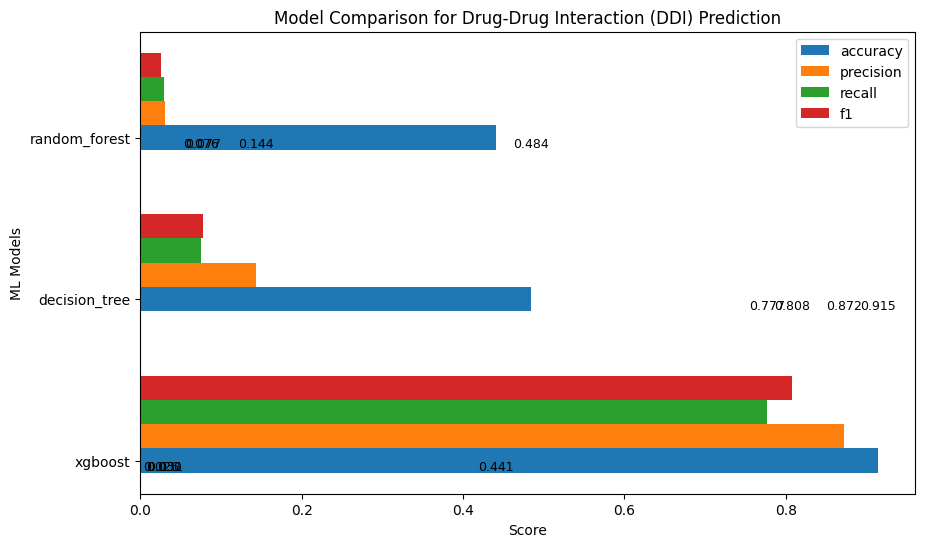

In [43]:
# compare the metrics
build_compare_metrics(df_metrics_hyp)

In [51]:
def build_confusion_matrix(df_metrics, y_val):
    cms = []
    model_names = []
    total_samples = []

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    for i, model_name in enumerate(df_metrics['model']):
        y_pred = df_metrics[df_metrics['model'] == model_name]['y_pred'].iloc[0]

        # Compute the confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        cms.append(cm)
        model_names.append(model_name)
        total_samples.append(np.sum(cm))

        # Plot the confusion matrix on the corresponding subplot
        ax = axes[i // 2, i % 2]
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax, shrink=0.6)

        # Loop to annotate each quadrant with its count
        for row in range(cm.shape[0]):
            for col in range(cm.shape[1]):
                ax.text(col, row, str(cm[row, col]), ha="center", va="center", color="white")

        ax.set_title(f"{model_name} - Total Samples: {total_samples[-1]}")
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('Actual', fontsize=10)
        ax.xaxis.set_label_position('top')
    # Adjust the layout
    plt.tight_layout()    

    plt.savefig('./images/ozkary-ml-ddi-model-confusion-matrix.png')

In [61]:
# save the xgboost model
model_factory.save('xgboost', './models/ozkary_ddi')

Saved model to ./models/ozkary_ddi_xgboost.pkl.bin
Saved encoder to ./models/ozkary_ddi_encoder.pkl.bin


In [64]:
# save the notebook into a python file
!jupyter nbconvert --to script data_train.ipynb
# move the python file to the ddi_lib folder
!mv data_train.py ./ddi_lib/

/usr/bin/jupyter:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
[NbConvertApp] Converting notebook data_train.ipynb to script
[NbConvertApp] Writing 14167 bytes to data_train.py
